In [6]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

sns.set_theme(style="whitegrid")

In [33]:
#Load all datasets
# Main Dataset

# Conversation Data -- we will use this data in the "Conversation Data" section
df = pd.read_json(
    "../data/training-set/chatbot-arena-conversations.jsonl.gz",
    lines=True,
    compression="gzip"
)
df.head(5)
# Auxiliary Datasets

# Embedding Data -- we will use this data in the "Embedding Data" section
prompt_embeddings = np.load(
    "../data/training-set/chatbot-arena-prompts-embeddings.npy"
)

response_a_embeddings = np.load(
    "../data/training-set/chatbot-arena-model_a_response-embeddings.npy"
)

response_b_embeddings = np.load(
    "../data/training-set/chatbot-arena-model_b_response-embeddings.npy"
)

# Topic Modeling and Hardness Score Data -- we will use this data in the "Topic Modeling and Hardness Score Data" section
topic_and_hardness = pd.read_json(
    "../data/training-set/chatbot-arena-gpt3-scores.jsonl.gz",
    lines=True,
    compression="gzip"
)

MINIMAL EDA REQUIREMENTS

Ranking of the model based on their win rate or ELO ratings. \
Distribution of the prompt and response length.\
Hardness score distribution and its correlation with the models (e.g. GPT4 wins on hardest prompts).\
(Open-ended) Visualize the “variance” in model performance (see LMSys Leaderboard for an example).\
(Open-ended) Explore the prompt topics in the dataset (topic modeling)

In [8]:
df.shape
# df.head(2)

(25282, 7)

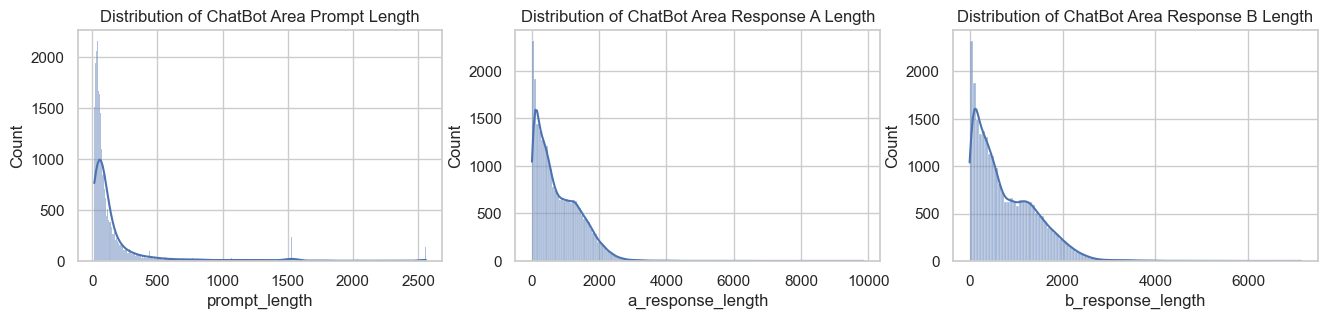

In [9]:
#Distribution of the prompt and response  (Histograms)
df["prompt"] = df["conversation_a"].str[0].str["content"]
df["prompt_length"] = df["prompt"].str.len()
df["response_a"] = df["conversation_a"].str[1].str["content"]
df["a_response_length"] = df["response_a"].str.len()
df["response_b"] = df["conversation_b"].str[1].str["content"]
df["b_response_length"] = df["response_b"].str.len()

fig, axes = plt.subplots(1, 3, figsize=(16, 3))  
sns.histplot(df["prompt_length"], kde=True, ax=axes[0])
axes[0].set_title("Distribution of ChatBot Area Prompt Length")

sns.histplot(df["a_response_length"], kde=True, ax=axes[1])
axes[1].set_title("Distribution of ChatBot Area Response A Length")

sns.histplot(df["b_response_length"], kde=True, ax=axes[2])
axes[2].set_title("Distribution of ChatBot Area Response B Length")

plt.show()

Text(0.5, 1.0, 'Distribution of Prompt Length')

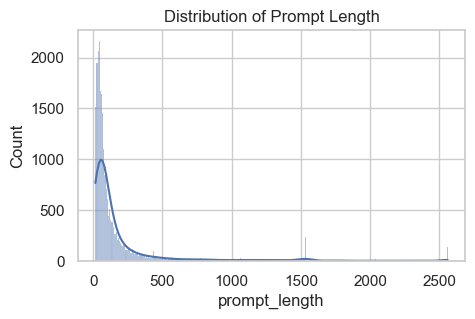

In [28]:
#combining both response series into a single series to plot length by whole dataset
plt.figure(figsize = (5,3))
sns.histplot(df["prompt_length"], kde=True)
plt.title("Distribution of Prompt Length")

(50604,)


Text(0.5, 0, 'response_length')

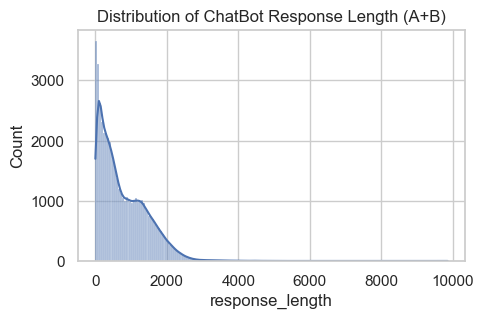

In [29]:
#combining both response series into a single series to plot length by whole dataset
plt.figure(figsize = (5,3))
combined_response_length = pd.concat([df["a_response_length"],df["b_response_length"]], ignore_index = True)
print(combined_response_length.shape)
sns.histplot(combined_response_length, kde=True)
plt.title("Distribution of ChatBot Response Length (A+B)")
plt.xlabel("response_length")

In [12]:
df.head(2)

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,prompt,prompt_length,response_a,a_response_length,response_b,b_response_length
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...,What is the difference between OpenCL and CUDA?,47,OpenCL and CUDA are two different programming ...,892,OpenCL and CUDA are both programming languages...,1905
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...,Why did my parent not invite me to their wedding?,49,It is possible that your parent did not invite...,660,It is likely that they wanted to keep the gues...,514


In [13]:
#Summary DataFrame 
prompt_stats = df["prompt_length"].describe()
a_response_stats = df["a_response_length"].describe()
b_response_stats = df["b_response_length"].describe()
combined_response_stats = combined_response_length.describe()

# Concatenate the results into a single DataFrame
stats_df = pd.concat([prompt_stats, a_response_stats, b_response_stats, combined_response_stats], axis=1)
stats_df.columns = ["Prompt Length", "Response A Length", "Response B Length", "Combined Response Length"]
stats_df


,Prompt Length,Response A Length,Response B Length,Combined Response Length
count,25282.00000,25282.000000,25282.000000,50564.000000
mean,196.74646,772.708409,773.163911,772.936160
std,369.05595,655.798032,658.803491,657.296019
min,16.00000,1.000000,1.000000,1.000000
25%,42.00000,232.000000,232.000000,232.000000
50%,72.00000,591.000000,582.000000,587.000000
75%,156.00000,1215.750000,1214.750000,1215.000000
max,2560.00000,9857.000000,7135.000000,9857.000000


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21],
 [Text(0, 0, 'RWKV-4-Raven-14B'),
  Text(1, 0, 'alpaca-13b'),
  Text(2, 0, 'chatglm-6b'),
  Text(3, 0, 'claude-instant-v1'),
  Text(4, 0, 'claude-v1'),
  Text(5, 0, 'dolly-v2-12b'),
  Text(6, 0, 'fastchat-t5-3b'),
  Text(7, 0, 'gpt-3.5-turbo'),
  Text(8, 0, 'gpt-4'),
  Text(9, 0, 'gpt4all-13b-snoozy'),
  Text(10, 0, 'guanaco-33b'),
  Text(11, 0, 'koala-13b'),
  Text(12, 0, 'llama-13b'),
  Text(13, 0, 'mpt-7b-chat'),
  Text(14, 0, 'oasst-pythia-12b'),
  Text(15, 0, 'palm-2'),
  Text(16, 0, 'stablelm-tuned-alpha-7b'),
  Text(17, 0, 'tie'),
  Text(18, 0, 'tie (bothbad)'),
  Text(19, 0, 'vicuna-13b'),
  Text(20, 0, 'vicuna-7b'),
  Text(21, 0, 'wizardlm-13b')])

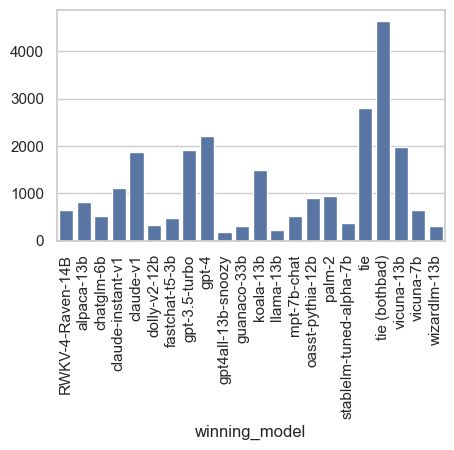

In [31]:
#Generating stats on win rate
plt.figure(figsize = (5,3))
df["winning_model"] = df.apply(
    lambda row: row["model_a"] if row["winner"] == "model_a" 
    else (row["model_b"] if row["winner"] == "model_b" 
          else row["winner"]),
    axis=1
)
outcome_stats = df.groupby(by="winning_model").size()
sns.barplot(outcome_stats)
plt.xticks(rotation=90)

In [32]:
#checking that there are no instances of models being the same per conversation
same_model = (df["model_a"] == df["model_b"])
print(same_model.value_counts())

False    25302
Name: count, dtype: int64


In [16]:
chatbot_distribution_a = df.groupby("model_a").size().reset_index()
chatbot_distribution_b = df.groupby("model_b").size().reset_index()

chatbot_distribution_a.merge(chatbot_distribution_b, left_on= "model_a", right_on="model_b")
chatbot_distribution = chatbot_distribution_a.rename(columns={"model_a": "model"})
chatbot_distribution

,model,0
0,RWKV-4-Raven-14B,1353
1,alpaca-13b,1619
2,chatglm-6b,1370
3,claude-instant-v1,1046
4,claude-v1,1562
5,dolly-v2-12b,1046
6,fastchat-t5-3b,1178
7,gpt-3.5-turbo,1779
8,gpt-4,1639
9,gpt4all-13b-snoozy,397


In [18]:
df.shape

(25282, 14)

In [19]:
# Get all unique models from 'model_a' and 'model_b'
models = pd.concat([df["model_a"], df["model_b"]]).unique()

# Initialize a list to store the outcome statistics for each model
outcome_stats = []

# Iterate over each unique model to calculate rates
for model in models:
    # Calculate the number of wins, losses, tie-good, and tie-bad for the current model
    wins = ((df["winner"] == "model_a") & (df["model_a"] == model)).sum() + \
           ((df["winner"] == "model_b") & (df["model_b"] == model)).sum()
    
    losses = ((df["winner"] == "model_a") & (df["model_b"] == model)).sum() + \
             ((df["winner"] == "model_b") & (df["model_a"] == model)).sum()
    
    tie_good = ((df["winner"] == "tie") & 
                ((df["model_a"] == model) | (df["model_b"] == model))).sum()
    
    tie_bad = ((df["winner"] == "tie (bothbad)") & 
               ((df["model_a"] == model) | (df["model_b"] == model))).sum()

    # Calculate the total number of matches involving this model
    total_matches = ((df["model_a"] == model) | (df["model_b"] == model)).sum()

    # Avoid division by zero by checking if total_matches > 0
    if total_matches > 0:
        win_rate = wins / total_matches
        loss_rate = losses / total_matches
        tie_good_rate = tie_good / total_matches
        tie_bad_rate = tie_bad / total_matches
    else:
        win_rate = loss_rate = tie_good_rate = tie_bad_rate = 0

    # Append the results to the list
    outcome_stats.append([model, win_rate, loss_rate, tie_good_rate, tie_bad_rate])

# Create a DataFrame from the list of outcome statistics
outcome_rate = pd.DataFrame(outcome_stats, 
                            columns=["Model", "Win Rate", "Loss Rate", 
                                     "Tie-Good Rate", "Tie-Bad Rate"])

# Display the outcome_rate DataFrame
outcome_rate = outcome_rate.set_index("Model")
outcome_rate

,Win Rate,Loss Rate,Tie-Good Rate,Tie-Bad Rate
Model,,,,
chatglm-6b,0.198138,0.470764,0.085289,0.245810
oasst-pythia-12b,0.241015,0.452431,0.087738,0.218816
koala-13b,0.350212,0.333961,0.121291,0.194536
vicuna-13b,0.438472,0.265215,0.140826,0.155486
stablelm-tuned-alpha-7b,0.178538,0.507401,0.073080,0.240981
alpaca-13b,0.244855,0.454817,0.079332,0.220996
llama-13b,0.147116,0.560596,0.058976,0.233312
dolly-v2-12b,0.155609,0.537947,0.054893,0.251551
fastchat-t5-3b,0.197251,0.472110,0.084883,0.245756


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'gpt-4'),
  Text(1, 0, 'claude-v1'),
  Text(2, 0, 'claude-instant-v1'),
  Text(3, 0, 'gpt-3.5-turbo'),
  Text(4, 0, 'vicuna-13b'),
  Text(5, 0, 'guanaco-33b'),
  Text(6, 0, 'palm-2'),
  Text(7, 0, 'wizardlm-13b'),
  Text(8, 0, 'koala-13b'),
  Text(9, 0, 'vicuna-7b'),
  Text(10, 0, 'alpaca-13b'),
  Text(11, 0, 'oasst-pythia-12b'),
  Text(12, 0, 'mpt-7b-chat'),
  Text(13, 0, 'gpt4all-13b-snoozy'),
  Text(14, 0, 'RWKV-4-Raven-14B'),
  Text(15, 0, 'chatglm-6b'),
  Text(16, 0, 'fastchat-t5-3b'),
  Text(17, 0, 'stablelm-tuned-alpha-7b'),
  Text(18, 0, 'dolly-v2-12b'),
  Text(19, 0, 'llama-13b')])

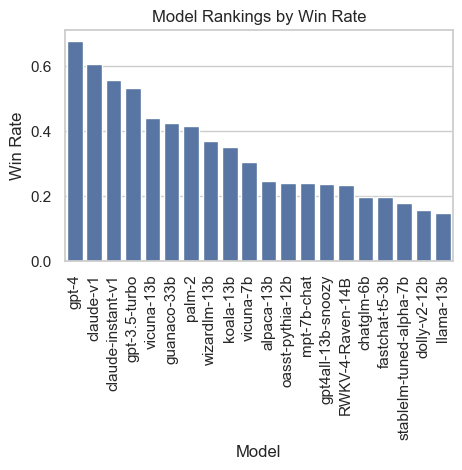

In [20]:
model_ranking = outcome_rate["Win Rate"].sort_values(ascending = False)
model_ranking
plt.figure(figsize = (5,3))
sns.barplot(data = model_ranking)
plt.title("Model Rankings by Win Rate")
plt.xticks(rotation = 90)